In [1]:
import pandas as pd                                            
import numpy as np                                             # dense matrices
import matplotlib.pyplot as plt                                # plotting
from scipy.stats import multivariate_normal                    # multivariate Gaussian distribution
import copy                                                    # deep copies

# image handling library
from PIL import Image
from io import BytesIO

%matplotlib inline

In [2]:
#Log likelihood
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

In [3]:
#E-step: assign cluster responsibilities, given current parameters.
'''
Draw from a Gaussian distribution.
multivariate_normal.pdf([data point], mean=[mean vector], cov=[covariance matrix])
'''

def compute_responsibilities(data, weights, means, covariances):
    '''E-step: compute responsibilities, given the current parameters'''
    num_data = len(data)
    num_clusters = len(means)
    resp = np.zeros((num_data, num_clusters))
    
    # Update resp matrix so that resp[i,k] is the responsibility of cluster k for data point i.
    # Hint: To compute likelihood of seeing data point i given cluster k, use multivariate_normal.pdf.
    for i in range(num_data):
        for k in range(num_clusters):
            resp[i, k] = weights[k]*multivariate_normal.pdf(data[i], mean=means[k], cov=covariances[k])
    
    # Add up responsibilities over each data point and normalize
    row_sums = resp.sum(axis=1)[:, np.newaxis]
    resp = resp / row_sums
    
    return resp

#Checkpoint.
resp = compute_responsibilities(data=np.array([[1.,2.],[-1.,-2.]]), weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])

if resp.shape==(2,2) and np.allclose(resp, np.array([[0.10512733, 0.89487267], [0.46468164, 0.53531836]])):
    print('Checkpoint passed!')
else:
    print('Check your code again.')

Checkpoint passed!


In [4]:
#M-step: Update parameters, given current cluster responsibilities.
#Compute soft counts
def compute_soft_counts(resp):
    # Compute the total responsibility assigned to each cluster, which will be useful when 
    # implementing M-steps below. In the lectures this is called N^{soft}
    counts = np.sum(resp, axis=0)
    return counts

#Update weights
def compute_weights(counts):
    num_clusters = len(counts)
    weights = [0.] * num_clusters
    
    for k in range(num_clusters):
        # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
        # HINT: compute # of data points by summing soft counts.
        weights[k] = counts[k] / np.sum(counts)

    return weights

#Checkpoint
resp = compute_responsibilities(data=np.array([[1.,2.],[-1.,-2.],[0,0]]), weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
weights = compute_weights(counts)

print(counts)
print(weights)

if np.allclose(weights, [0.27904865942515705, 0.720951340574843]):
    print('Checkpoint passed!')
else:
    print('Check your code again.')

[ 0.83714598  2.16285402]
[0.27904865942515705, 0.720951340574843]
Checkpoint passed!


In [5]:
#Update means
def compute_means(data, resp, counts):
    num_clusters = len(counts)
    num_data = len(data)
    means = [np.zeros(len(data[0]))] * num_clusters
    
    for k in range(num_clusters):
        # Update means for cluster k using the M-step update rule for the mean variables.
        # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
        weighted_sum = 0.
        for i in range(num_data):
            weighted_sum += data[i] * resp[i][k]
        means[k] = weighted_sum/counts[k]

    return means

#Checkpoint
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)

if np.allclose(means, np.array([[-0.6310085, -1.262017], [0.25140299, 0.50280599]])):
    print('Checkpoint passed!')
else:
    print('Check your code again.')

Checkpoint passed!


In [6]:
#Update covariances
def compute_covariances(data, resp, counts, means):
    num_clusters = len(counts)
    num_dim = len(data[0])
    num_data = len(data)
    covariances = [np.zeros((num_dim,num_dim))] * num_clusters
    
    for k in range(num_clusters):
        # Update covariances for cluster k using the M-step update rule for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
        weighted_sum = np.zeros((num_dim, num_dim))
        for i in range(num_data):
            #Hint: Use np.outer on the data[i] and this cluster's mean
            #The "outer product" in this context refers to the matrix product
            weighted_sum += resp[i][k] * np.outer(data[i] - means[k], data[i] - means[k])
        covariances[k] = weighted_sum / counts[k]

    return covariances

#Checkpoint
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)
covariances = compute_covariances(data_tmp, resp, counts, means)

if np.allclose(covariances[0], np.array([[0.60182827, 1.20365655], [1.20365655, 2.4073131]])) and \
    np.allclose(covariances[1], np.array([[ 0.93679654, 1.87359307], [1.87359307, 3.74718614]])):
    print('Checkpoint passed!')
else:
    print('Check your code again.')

Checkpoint passed!


In [7]:
#The EM algorithm
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for it in range(maxiter):
        if it % 5 == 0:
            print("Iteration %s" % it)
        
        # E-step: compute responsibilities
        resp = compute_responsibilities(data, weights, means, covariances)

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = compute_soft_counts(resp)
        
        # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
        weights = compute_weights(counts)
        
        # Update means for cluster k using the M-step update rule for the mean variables.
        # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
        means = compute_means(data, resp, counts)
        
        # Update covariances for cluster k using the M-step update rule for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
        covariances = compute_covariances(data, resp, counts, means)
        
        # Compute the loglikelihood at this iteration
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if it % 5 != 0:
        print("Iteration %s" % it)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

In [10]:
#Test the implementation on the simulated data
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

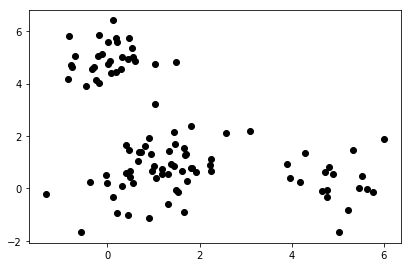

In [11]:
#plot the data you created above
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [12]:
#fit a mixture of Gaussians to this data using implementation of the EM algorithm
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)
#weights
print(results['weights'])
#means
print(results['means'])
#covariances
print(results['covs'])

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22
[0.30071023006098241, 0.17993710074247016, 0.51935266919654743]
[array([ 0.02138285,  4.947729  ]), array([ 4.94239235,  0.31365311]), array([ 1.08181125,  0.73903508])]
[array([[ 0.2932614 ,  0.05048455],
       [ 0.05048455,  0.35281537]]), array([[ 0.3556437 , -0.01494875],
       [-0.01494875,  0.66695025]]), array([[ 0.67114992,  0.33058965],
       [ 0.33058965,  0.90429724]])]


Iteration 0
Iteration 4
Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


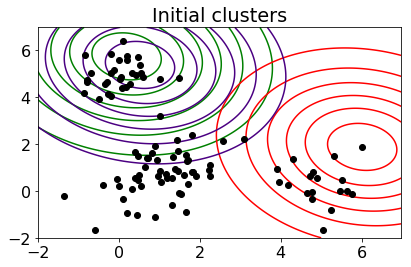

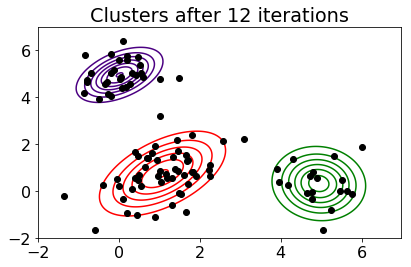

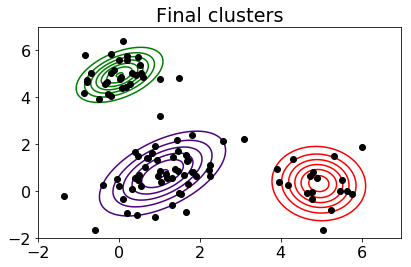

In [13]:
#Plot progress of parameters
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

# Parameters after initialization
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

# Parameters after 12 iterations
results = EM(data, init_means, init_covariances, init_weights, maxiter=12, thresh=1e-4)
plot_contours(data, results['means'], results['covs'], 'Clusters after 12 iterations')

# Parameters after running EM to convergence
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')    

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


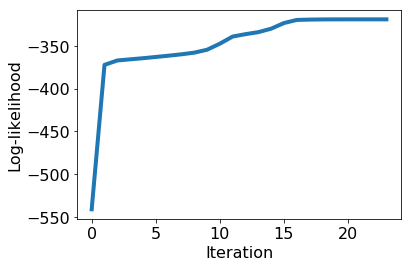

In [13]:
#Plot the loglikelihood that is observed at each iteration
results = EM(data, initial_means, initial_covs, initial_weights)

loglikelihoods = results['loglik']

plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()
#the loglikelihood plot is monotonically increasing

In [14]:
#Fit a Gaussian mixture model for image data
#import images
import os
from PIL import ImageStat
import pandas as pd
import numpy as np
import csv

# Import the photos
rgb_picture_array = []
for folder in os.listdir('images'):
    for filename in os.listdir('images/'+folder):
        if filename.endswith(".jpg"): 
            im = Image.open('images/'+folder+'/'+filename)
            #Get RGB mean values per image
            means = ImageStat.Stat(im).mean
            #Store filename and RGB Values
            rgb_picture_array.append( (filename, np.array(means)/256) )

# create the dataframe
df = pd.DataFrame(rgb_picture_array)
df.columns=['filename', 'rgb']
df['red'] = df['rgb'].apply(lambda row: row[0])
df['green'] = df['rgb'].apply(lambda row: row[1])
df['blue'] = df['rgb'].apply(lambda row: row[2])

# sort the dataframe to match the SFrame provided for the course
with open('ordered_filenames.csv', 'rt') as file:
    reader = csv.reader(file)
    paths = np.array(list(reader)).flatten()

df['filename'] = df['filename'].astype('category')
df['filename'].cat.set_categories(paths, inplace=True)
df = df.sort_values(['filename'])

In [16]:
df.head(3)

filename  \
888  ANd9GcSN4TPL6_XoTvZeg3-15UhGnWAwjhbxQLjTNiCpWI...   
669  ANd9GcQeme67tTCcvFbjg3xtvKPls3300iLBXVDEUfy8mx...   
852  ANd9GcSAb2GMlHYIvV8eXZuUskgqHA-Oo2LfLjw3FsyeSD...   

                                                  rgb       red     green  \
888   [0.402697711634, 0.254471982222, 0.29761650803]  0.402698  0.254472   
669  [0.55500352329, 0.246767155594, 0.0481496661426]  0.555004  0.246767   
852  [0.529754098361, 0.11515454235, 0.0742614412568]  0.529754  0.115155   

         blue  
888  0.297617  
669  0.048150  
852  0.074261

In [17]:
#Initialization
np.random.seed(1)

# Initalize parameters
init_means = [df['rgb'][x] for x in np.random.choice(len(df), 4, replace=False)]
cov = np.diag([df['red'].var(), df['green'].var(), df['blue'].var()])
init_covariances = [cov, cov, cov, cov]
init_weights = [1/4., 1/4., 1/4., 1/4.]

# Convert rgb data to numpy arrays
img_data = [np.array(i) for i in df['rgb']]  

# Run our EM algorithm on the image data using the above initializations. 
# This should converge in about 125 iterations
out = EM(img_data, init_means, init_covariances, init_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Iteration 70
Iteration 75
Iteration 80
Iteration 82


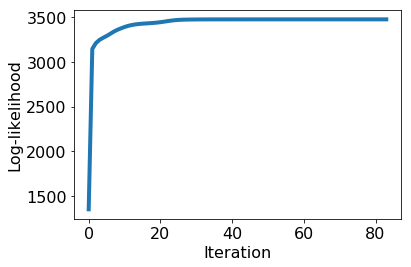

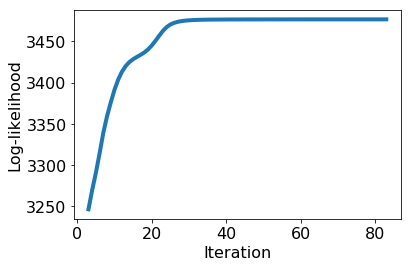

In [18]:
#Evaluate convergence
ll = out['loglik']
plt.plot(range(len(ll)),ll,linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()
#The log likelihood increases so quickly on the first few iterations that we can barely see the plotted line
plt.figure()
plt.plot(range(3,len(ll)),ll[3:],linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Iteration 0
Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 19


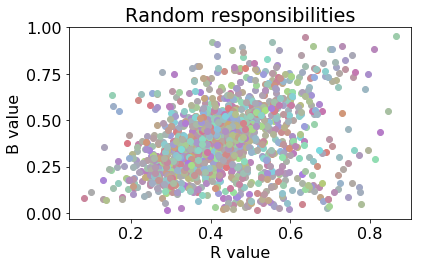

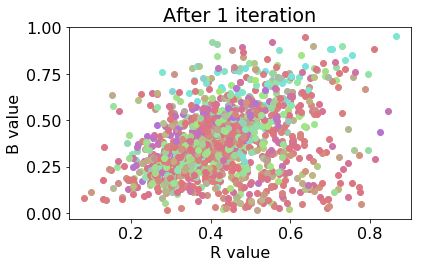

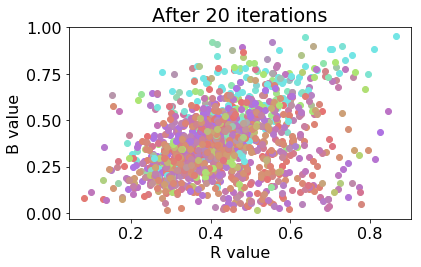

In [19]:
#Evaluate uncertainty
import colorsys
def plot_responsibilities_in_RB(img, resp, title):
    N, K = resp.shape
    
    HSV_tuples = [(x*1.0/K, 0.5, 0.9) for x in range(K)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    #has to cast list()
    
    R = img['red']
    B = img['blue']
    resp_by_img_int = [[resp[n][k] for k in range(K)] for n in range(N)]
    cols = [tuple(np.dot(resp_by_img_int[n], np.array(RGB_tuples))) for n in range(N)]

    plt.figure()
    for n in range(len(R)):
        plt.plot(R[n], B[n], 'o', c=cols[n])
    plt.title(title)
    plt.xlabel('R value')
    plt.ylabel('B value')
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()
    
#visualize what happens when each data has random responsibilities
N, K = out['resp'].shape
random_resp = np.random.dirichlet(np.ones(K), N)
plot_responsibilities_in_RB(df, random_resp, 'Random responsibilities')

#visualize the responsibilities after 1 iteration
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=1)
plot_responsibilities_in_RB(df, out['resp'], 'After 1 iteration')

#visualize the responsibilities after 20 iterations
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=20)
plot_responsibilities_in_RB(df, out['resp'], 'After 20 iterations')

In [19]:
#Interpret each cluste
'''
Let's dig into the clusters obtained from our EM implementation. 
Recall that our goal in this section is to cluster images based on their RGB values. 
We can evaluate the quality of our clustering by taking a look at a few images that 'belong' to each cluster. 
We hope to find that the clusters discovered by our EM algorithm correspond to different image categories 
- in this case, we know that our images came from four categories ('cloudy sky', 'rivers', 'sunsets', and 'trees and forests'), 
so we would expect to find that each component of our fitted mixture model roughly corresponds to one of these categories.

If we want to examine some example images from each cluster, 
we first need to consider how we can determine cluster assignments of the images from our algorithm output. 
This was easy with k-means - every data point had a 'hard' assignment to a single cluster, 
and all we had to do was find the cluster center closest to the data point of interest. 
Here, our clusters are described by probability distributions (specifically, Gaussians) rather than single points, 
and our model maintains some uncertainty about the cluster assignment of each observation.

One way to phrase the question of cluster assignment for mixture models is as follows: 
how do we calculate the distance of a point from a distribution? 
Note that simple Euclidean distance might not be appropriate 
since (non-scaled) Euclidean distance doesn't take direction into account. 
For example, if a Gaussian mixture component is very stretched in one direction but narrow in another, 
then a data point one unit away along the 'stretched' dimension has much higher probability 
(and so would be thought of as closer) than a data point one unit away along the 'narrow' dimension.

In fact, the correct distance metric to use in this case is known as Mahalanobis distance. 
For a Gaussian distribution, this distance is proportional to the square root of the negative log likelihood. 
This makes sense intuitively 
- reducing the Mahalanobis distance of an observation from a cluster is equivalent to increasing that observation's probability 
according to the Gaussian that is used to represent the cluster. 
This also means that we can find the cluster assignment of an observation by taking the Gaussian component
for which that observation scores highest. We'll use this fact to find the top examples that are 'closest' to each cluster.
'''

"\nLet's dig into the clusters obtained from our EM implementation. \nRecall that our goal in this section is to cluster images based on their RGB values. \nWe can evaluate the quality of our clustering by taking a look at a few images that 'belong' to each cluster. \nWe hope to find that the clusters discovered by our EM algorithm correspond to different image categories \n- in this case, we know that our images came from four categories ('cloudy sky', 'rivers', 'sunsets', and 'trees and forests'), \nso we would expect to find that each component of our fitted mixture model roughly corresponds to one of these categories.\n\nIf we want to examine some example images from each cluster, \nwe first need to consider how we can determine cluster assignments of the images from our algorithm output. \nThis was easy with k-means - every data point had a 'hard' assignment to a single cluster, \nand all we had to do was find the cluster center closest to the data point of interest. \nHere, our c

In [20]:
#cluster assignments for the entire image dataset using the result of running EM for 20 iterations
weights = out['weights']
means = out['means']
covariances = out['covs']
rgb = df['rgb']
N = len(df) # number of images
K = len(means) # number of clusters

assignments = [0]*N
probs = [0]*N

for i in range(N):
    # Compute the score of data point i under each Gaussian component:
    p = np.zeros(K)
    for k in range(K):
        p[k] = weights[k]*multivariate_normal.pdf(rgb[i], mean=means[k], cov=covariances[k])
        
    # Compute assignments of each data point to a given cluster based on the above scores:
    assignments[i] = np.argmax(p)
    
    # For data point i, store the corresponding score under this cluster assignment:
    probs[i] = np.max(p)

assigns = pd.DataFrame({'assignment': assignments, 'prob': probs, 'image': df['filename'].tolist()})    

In [30]:
assigns.head(5)

assignment                                              image       prob
0           3  ANd9GcSN4TPL6_XoTvZeg3-15UhGnWAwjhbxQLjTNiCpWI...  72.477305
1           0  ANd9GcQeme67tTCcvFbjg3xtvKPls3300iLBXVDEUfy8mx...   2.371328
2           0  ANd9GcSAb2GMlHYIvV8eXZuUskgqHA-Oo2LfLjw3FsyeSD...   4.164026
3           3  ANd9GcRs4-CSokZQJFe9vodGC6fK7ouonFopisgxltdHeL...  79.373368
4           3  ANd9GcQov2JpsVI0UO50J4NiyhsuxMNw90ffXe6U7PCHVJ...  93.901080

In [24]:
df.head(3)

filename  \
888  ANd9GcSN4TPL6_XoTvZeg3-15UhGnWAwjhbxQLjTNiCpWI...   
669  ANd9GcQeme67tTCcvFbjg3xtvKPls3300iLBXVDEUfy8mx...   
852  ANd9GcSAb2GMlHYIvV8eXZuUskgqHA-Oo2LfLjw3FsyeSD...   

                                                  rgb       red     green  \
888   [0.402697711634, 0.254471982222, 0.29761650803]  0.402698  0.254472   
669  [0.55500352329, 0.246767155594, 0.0481496661426]  0.555004  0.246767   
852  [0.529754098361, 0.11515454235, 0.0742614412568]  0.529754  0.115155   

         blue  
888  0.297617  
669  0.048150  
852  0.074261

Component 0


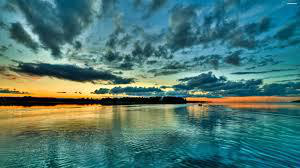

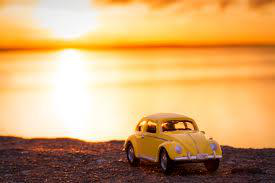

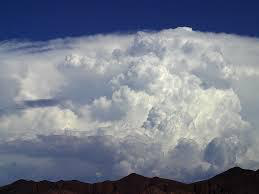

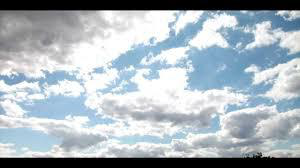

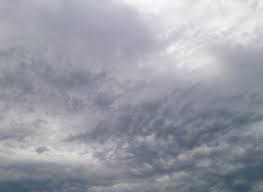



Component 1


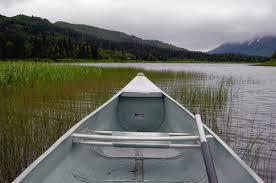

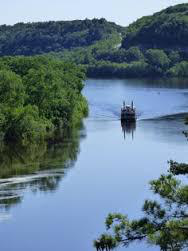

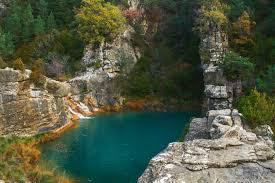

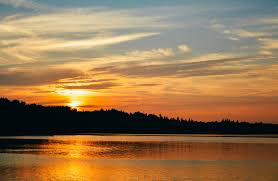

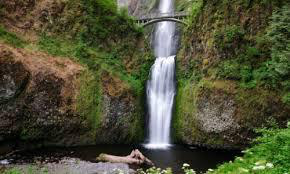



Component 2


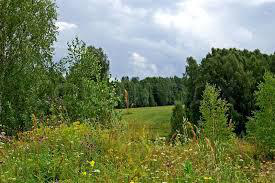

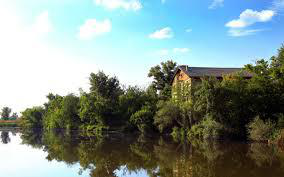

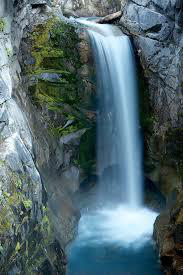

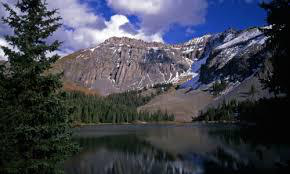

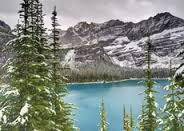



Component 3


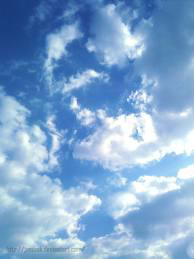

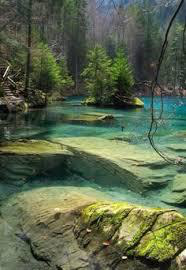

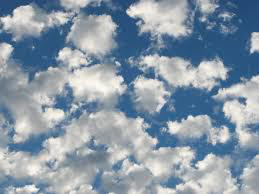

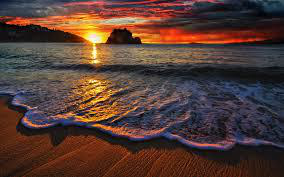

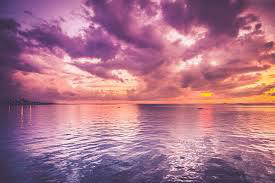

In [26]:
#returns the top 5 images assigned to a given category
def get_top_images(assigns, cluster, k=5):
    
    images_in_cluster = assigns[assigns['assignment']==cluster]
    top_images = images_in_cluster.nlargest(k, 'prob')
    return top_images['image']

#Here are some utility function to display the top images
'''
def display_images(images):
    from IPython.display import display
    from PIL import Image
    from io import BytesIO
    
    for image in images:
        display(Image.open(BytesIO(image._image_data)))

def save_images(images, prefix):
    for i, image in enumerate(images):
        Image.open(BytesIO(image._image_data)).save(prefix % i)
'''

def display_images(images):
    from IPython.display import display
    from PIL import Image
    from io import BytesIO
    
    for image in images:
        for folder in os.listdir('images'):
            for filename in os.listdir('images/'+folder):
                if filename == image:  
                    #im = Image.fromarray(np.uint8(images[images.index[i]]))
                    #im.show(im) 
                    im = Image.open('images/'+folder+'/'+image)
                    display(im)

#display the top images        
for component_id in range(4):
    print('Component {0:d}'.format(component_id))
    images = get_top_images(assigns, component_id)
    display_images(images)
    #save_images(images, 'component_{0:d}_%d.jpg'.format(component_id))
    print('\n')        

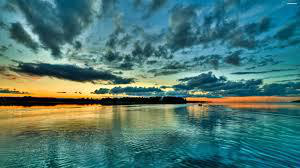

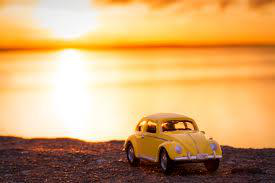

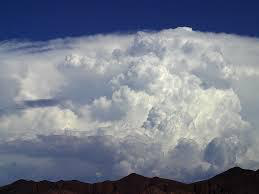

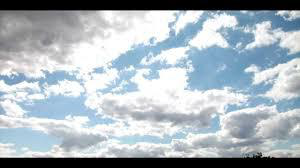

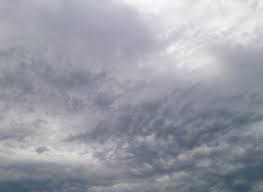

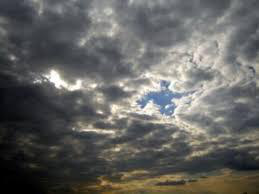

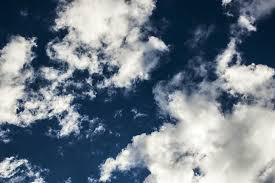

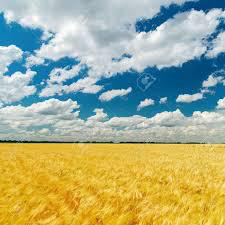

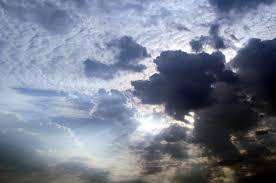

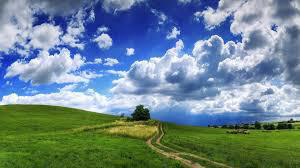

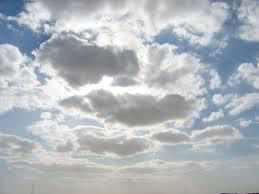

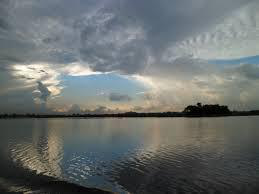

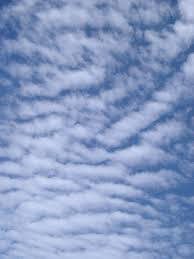

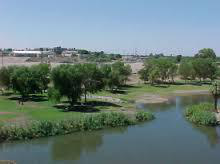

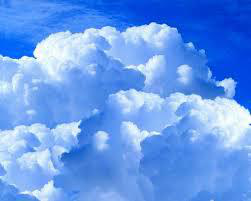

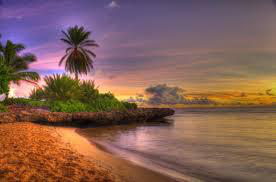

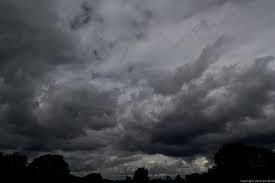

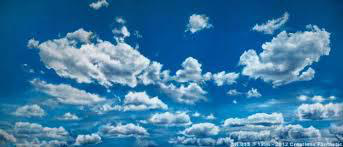

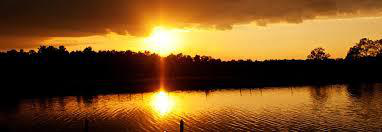

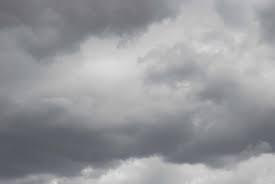

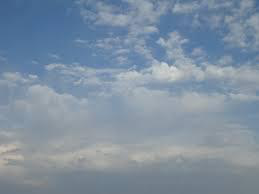

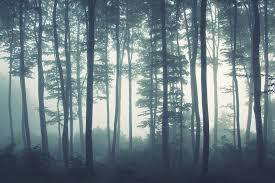

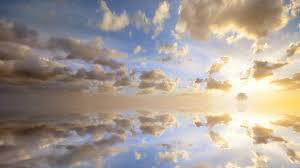

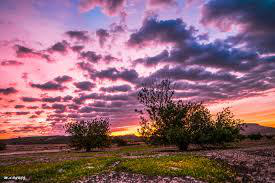

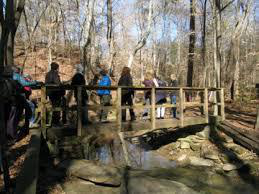

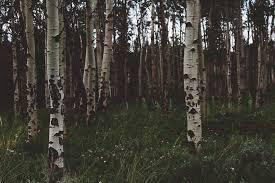

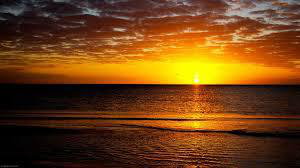

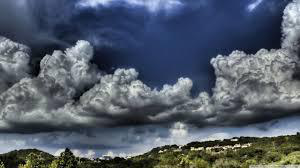

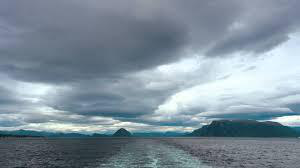

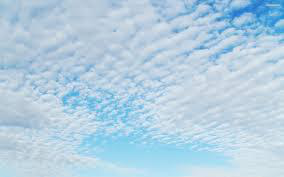

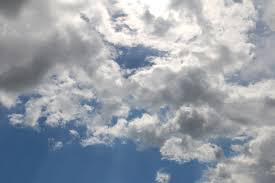

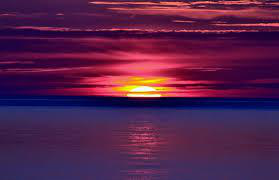

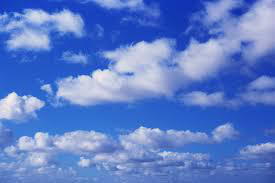

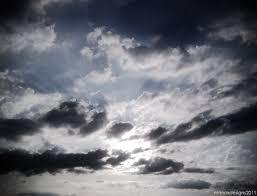

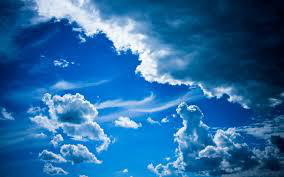

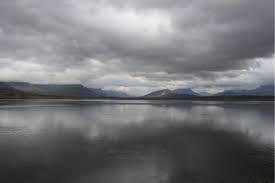

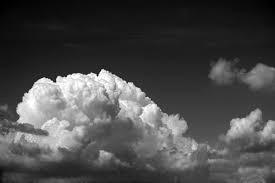

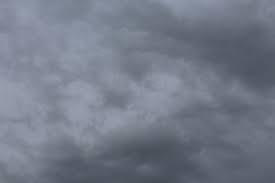

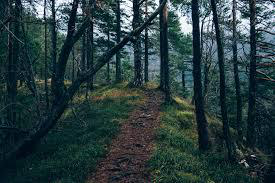

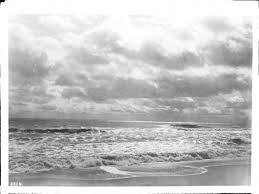

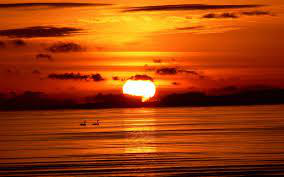

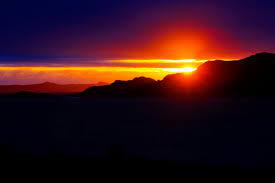

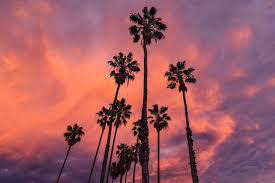

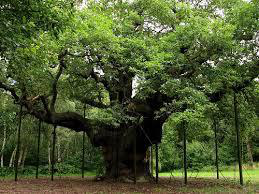

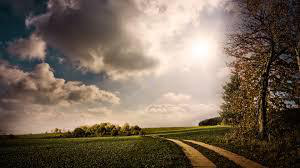

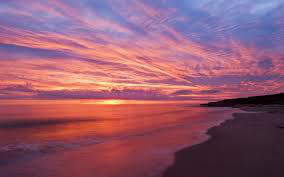

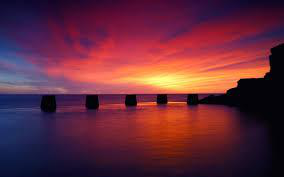

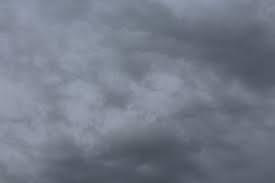

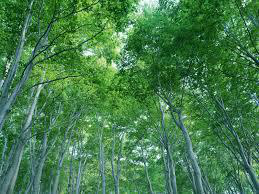

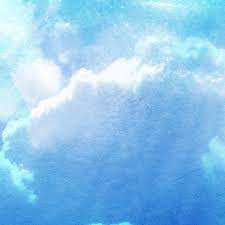

In [38]:
images_0 = get_top_images(assigns, 0, k=50)
display_images(images_0)

In [35]:
np.bincount(assigns['assignment'])

array([509, 169, 193, 457], dtype=int64)